<a href="https://colab.research.google.com/github/TuncerCemUgurluer/EEG_deception_detection/blob/code/Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [ ]:
sns.set_style('dark')
warnings.filterwarnings('ignore')

In [ ]:
eeg_channels = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2',
                'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']

In [ ]:
truth_files = [f"/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true{i}.csv" for i in range(1, 58)]
lie_files = [f"/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_Lie/Serkan_new_lie{i}.csv" for i in range(1, 58)]


In [ ]:
truth_files


['/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true1.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true2.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true3.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true4.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true5.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true6.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true7.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true8.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true9.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true10.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true11.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True/Serkan_new_true12.csv',
 '/content/drive/MyDrive/EEG/Serkan_new/Serkan_ne

In [ ]:
dataframes = []
labels = []

In [ ]:
for file in truth_files:
    df = pd.read_csv(file)
    df = df[eeg_channels]
    df = df.apply(lambda x: np.abs(fft(x.to_numpy())), axis=0)
    dataframes.append(df)
    labels.extend(['Truth'] * df.shape[0])

In [ ]:
for file in lie_files:
    df = pd.read_csv(file)
    df = df[eeg_channels]
    df = df.apply(lambda x: np.abs(fft(x.to_numpy())), axis=0)
    dataframes.append(df)
    labels.extend(['Lie'] * df.shape[0])

In [ ]:
df = pd.concat(dataframes, ignore_index=True)
df['label'] = labels

0         False
1         False
2         False
3         False
4         False
          ...  
115104    False
115105    False
115106    False
115107    False
115108    False
Name: label, Length: 115109, dtype: bool

<Axes: >

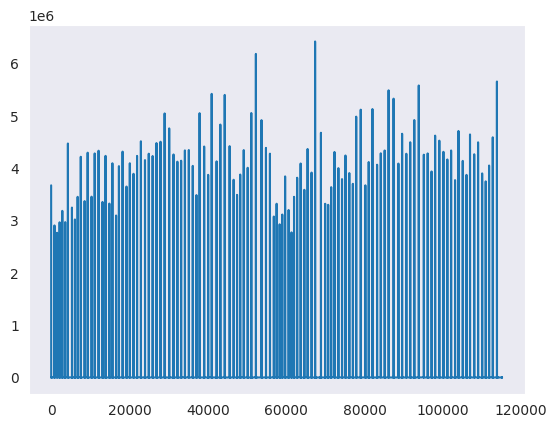

In [ ]:
df["EEG.AF3"].plot()

In [ ]:
Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

In [ ]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y, random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val = train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))
x_val = np.array(x_val).reshape((x_val.shape[0], x_val.shape[1], 1))


In [ ]:
Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)


In [ ]:
X_train.shape

(53238, 14, 1)

In [ ]:
i_lstm = Input(shape=(X_train.shape[1], 1))
x_lstm = LSTM(256, return_sequences=True)(i_lstm)
x_lstm = Flatten()(x_lstm)
y_lstm = Dense(Y_train.shape[1], activation='softmax')(x_lstm)
model_lstm = Model(i_lstm, y_lstm)

In [ ]:
adam = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

In [ ]:
model_lstm.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
lstm_h = model_lstm.fit(X_train, Y_train, batch_size=32, validation_data=(x_val, y_val), epochs=50, callbacks=[es, mc, lr_schedule])


Epoch 1/50
1662/1664 [============================>.] - ETA: 0s - loss: 0.5037 - accuracy: 0.6938
Epoch 1: val_accuracy improved from -inf to 0.75759, saving model to ./best_lstm_model.h5
1664/1664 [==============================] - 15s 5ms/step - loss: 0.5036 - accuracy: 0.6939 - val_loss: 0.4404 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 2/50
1659/1664 [============================>.] - ETA: 0s - loss: 0.3573 - accuracy: 0.7743
Epoch 2: val_accuracy improved from 0.75759 to 0.77197, saving model to ./best_lstm_model.h5
1664/1664 [==============================] - 8s 5ms/step - loss: 0.3571 - accuracy: 0.7744 - val_loss: 0.3491 - val_accuracy: 0.7720 - lr: 9.0484e-04
Epoch 3/50
1664/1664 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.7806
Epoch 3: val_accuracy improved from 0.77197 to 0.77845, saving model to ./best_lstm_model.h5
1664/1664 [==============================] - 8s 5ms/step - loss: 0.3412 - accuracy: 0.7806 - val_loss: 0.3404 - val_accuracy: 0.7785 

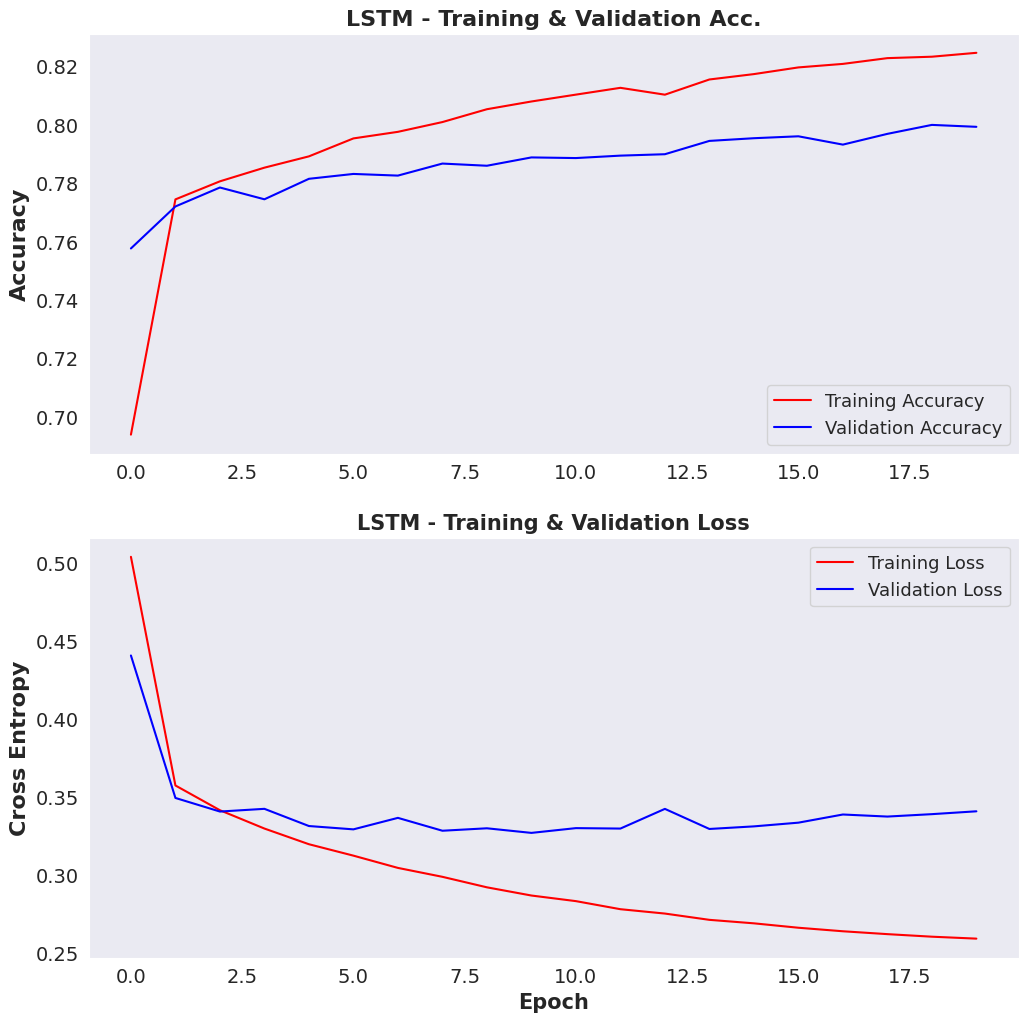

In [ ]:
acc = lstm_h.history['accuracy']
val_acc = lstm_h.history['val_accuracy']

loss = lstm_h.history['loss']
val_loss = lstm_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()


1019/1019 [==============================] - 3s 2ms/step


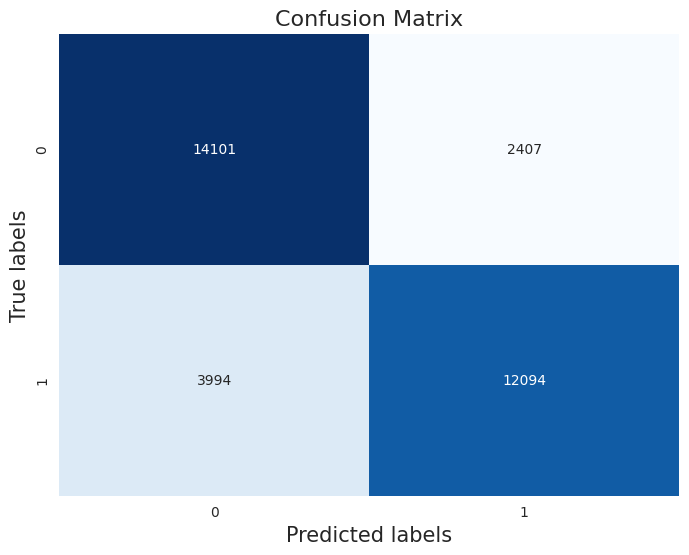

              precision    recall  f1-score   support

       Truth       0.78      0.85      0.82     16508
         Lie       0.83      0.75      0.79     16088

    accuracy                           0.80     32596
   macro avg       0.81      0.80      0.80     32596
weighted avg       0.81      0.80      0.80     32596



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load best model
best_model = load_model('./best_lstm_model.h5')

# Evaluate on test set
y_pred_probs = best_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(np.array(y_test), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

print(classification_report(y_true, y_pred, target_names=['Truth', 'Lie']))


In [ ]:
/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_True

In [ ]:
unseen_files = [f"/content/drive/MyDrive/EEG/Umut/Umut_Lie/Umut_lie{i}.csv" for i in range(1, 21)]  # Note the range is changed to start from 58

def preprocess_data(file):
    df = pd.read_csv(file)
    df = df[eeg_channels]
    df = df.apply(lambda x: np.abs(fft(x.to_numpy())), axis=0)

    return np.array(df).reshape((df.shape[0], df.shape[1], 1))

def get_majority_vote(predictions):
    truth_count = np.sum(predictions == 0)
    lie_count = np.sum(predictions == 1)

    return 'Truth' if truth_count > lie_count else 'Lie'

for file in unseen_files:
    unseen_data = preprocess_data(file)
    predictions_probs = best_model.predict(unseen_data)
    predictions = np.argmax(predictions_probs, axis=1)

    result = get_majority_vote(predictions)
    print(f"{file.split('/')[-1]} -> {result}")

28/28 [==============================] - 0s 2ms/step
Umut_lie1.csv -> Truth
29/29 [==============================] - 0s 2ms/step
Umut_lie2.csv -> Lie
27/27 [==============================] - 0s 2ms/step
Umut_lie3.csv -> Lie
26/26 [==============================] - 0s 2ms/step
Umut_lie4.csv -> Truth
37/37 [==============================] - 0s 2ms/step
Umut_lie5.csv -> Lie
32/32 [==============================] - 0s 2ms/step
Umut_lie6.csv -> Lie
28/28 [==============================] - 0s 2ms/step
Umut_lie7.csv -> Lie
28/28 [==============================] - 0s 2ms/step
Umut_lie8.csv -> Truth
28/28 [==============================] - 0s 2ms/step
Umut_lie9.csv -> Lie
23/23 [==============================] - 0s 2ms/step
Umut_lie10.csv -> Truth
30/30 [==============================] - 0s 2ms/step
Umut_lie11.csv -> Truth
32/32 [==============================] - 0s 2ms/step
Umut_lie12.csv -> Truth
31/31 [==============================] - 0s 2ms/step
Umut_lie13.csv -> Lie
31/31 [===============

In [ ]:
import numpy as np
import pandas as pd
from scipy.fft import fft

# Assuming your model and eeg_channels are already defined

# File paths
unseen_files = [f"/content/drive/MyDrive/EEG/Serkan_new/Serkan_new_Lie/Serkan_new_lie{i}.csv" for i in range(58, 61)]  # Or however many files you have

def preprocess_data(file):
    df = pd.read_csv(file)
    df = df[eeg_channels]
    df = df.apply(lambda x: np.abs(fft(x.to_numpy())), axis=0)

    return np.array(df).reshape((df.shape[0], df.shape[1], 1))

def get_majority_vote(predictions):
    # Assuming 0 stands for 'Truth' and 1 for 'Lie'
    return 'Truth' if np.mean(predictions) < 0.5 else 'Lie'

for file in unseen_files:
    data = preprocess_data(file)
    predictions_probs = best_model.predict(data)
    predictions = np.argmax(predictions_probs, axis=1)

    result = get_majority_vote(predictions)
    file_name = file.split('/')[-1].replace('.csv', '')
    print(f"{file_name} -> {result}")


30/30 [==============================] - 0s 2ms/step
Serkan_new_lie58 -> Lie
34/34 [==============================] - 0s 2ms/step
Serkan_new_lie59 -> Lie
41/41 [==============================] - 0s 2ms/step
Serkan_new_lie60 -> Truth
